# TL;DR
The Titanic was a luxury liner that sank on its maiden voyage on April 15, 1912 after hitting an iceberg. 1,517 people died in the disaster and only 712 survived. In this competition, we would like to predict according to a prediction model that was built whether a certain person survived or not. In order to build a model that is as accurate as possible, we will investigate the characteristics that include the passenger data and try to find a connection between them and their chance of survival. In addition, we will perform several experiments with different prediction models that we learned for a binary classification problem and we will make a decision on which model to use according to their accuracy.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports and Definitions

In [ ]:
!pip install -U kaleido

In [ ]:
# import numpy, matplotlib, etc.
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# sklearn imports
import sklearn

from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams["legend.title_fontsize"] = 20


random_seed = 42

# Data Investigation

In [ ]:
train_df = pd.read_csv("/kaggle/input/train (1).csv")
test_df = pd.read_csv("/kaggle/input/test (1).csv")
submission = pd.read_csv("/kaggle/input/gender_submission.csv")

In [ ]:
train_df.info()

In [ ]:
test_df.info()

In [ ]:
train_df.head(5)

In [ ]:
test_df.head(5)

# Preprocessing

**fill empty values**

In [ ]:
# replace all empty values to np.NaN values
train_df.replace('', np.NaN, inplace=True)
train_df.fillna(np.NaN, inplace=True)
test_df.replace('', np.NaN, inplace=True)
test_df.fillna(np.NaN, inplace=True)

In [ ]:
# fill empty values in the dataframe
def fill_na_median(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    df.fillna({column_name: df_not_null[column_name].median()}, inplace=True)
    
def fill_na_mean(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    df.fillna({column_name: df_not_null[column_name].mean()}, inplace=True)

def fill_na_random_pick_column_distribution(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    # use lambda func to choose randomly from
    df[column_name] = df[column_name].apply(lambda x: np.random.choice(df_not_null[column_name]) if pd.isnull(x) else x)

    
fill_na_median(train_df,'Age')
fill_na_random_pick_column_distribution(train_df,'Embarked')

#we will drop cabin because its mostly empty
train_df_no_cabin = train_df.copy()
train_df_no_cabin = train_df_no_cabin.drop(['Cabin'], axis=1)

fill_na_median(test_df,'Age')
fill_na_mean(test_df,'Fare')
fill_na_random_pick_column_distribution(test_df,'Cabin')

***encoding categorical with oneHotEn***

In [ ]:
# using OneHotEncoder from sklearn to change Sex to 0/1 values and Embarked
train_df_cat = train_df_no_cabin[['Sex', 'Embarked']]
enc = OneHotEncoder(drop='first', sparse_output=False)
# change column names with original column name
train_df_cat_enc = pd.DataFrame(enc.fit_transform(train_df_cat),columns=enc.get_feature_names_out(['Sex', 'Embarked']))
# join two df - add columns
train_df_no_cabin = train_df_no_cabin.drop(['Sex', 'Embarked'], axis=1).join(train_df_cat_enc)
# deleting non-essential features 
train_df_no_cabin = train_df_no_cabin.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

# Regplot

In [ ]:
# get color map
def get_sns_cmap(n, name='muted'):
    return sns.color_palette(palette=name, n_colors=n)

# plot with regression line target values by each feature
def plot_reg_target_values_by_each_feature(df, target_column_name):
    nrows = math.ceil(math.sqrt(len(df.columns)-1))
    ncols = math.ceil((len(df.columns)-1)/nrows)
    fig, axes = plt.subplots(nrows, ncols)
    plt.subplots_adjust(top=3.2, bottom=0, left=0, right=2.5)
    colors = get_sns_cmap(len(df.columns))

    counter = 0
    for i in range(len(df.columns)-1):
        ax = sns.regplot(x=df.columns[i], y=target_column_name, data=df, color=colors[i], ax=axes[i//nrows, i%nrows], scatter_kws={"s": 20})
        ax.set_title(label=f'{df.columns[i]} by {target_column_name}', fontsize=10)

    for i in range(len(df.columns)-1, nrows*ncols):
        fig.delaxes(axes.flatten()[i])


plot_reg_target_values_by_each_feature(train_df_no_cabin, 'Survived')

In [ ]:
def show_heatmap(data):
    # show absolute correlation between features in a heatmap
    plt.figure(figsize=(24,20))
    cor = abs(data.corr())
    sns.heatmap(cor, annot=True,
            cmap=plt.cm.Greens, vmin=-1, vmax=1) # the lemits beetween -1 to 1
    plt.show()
    return cor

# heat map

In [ ]:
cor = show_heatmap(train_df_no_cabin)

In [ ]:
# We will search the low correlation features with SalePrice and show them
low_correlation_features = cor[cor['Survived'] < 0.1].index
print(low_correlation_features)

# drop low corrlations features from train_df and test_df
train_df_no_cabin.drop(low_correlation_features, axis=1, inplace=True)

# Train Validation Split

In [ ]:
# print 4 graphs: mse of train/test and r2 of train/test
def print_graphs_r2_mse(graph_points):
    for k, v in graph_points.items():
        best_value = max(v.values()) if 'R2' in k else min(v.values())
        best_index = np.argmax(list(v.values())) if 'R2' in k else np.argmin(list(v.values()))
        color = 'red' if 'train' in k else 'blue'
        fig = px.scatter(x=v.keys(), y=v.values(), title=f'{k}, best value: x={best_index + 1}, y={best_value}', color_discrete_sequence=[color])
        fig.data[0].update(mode='markers+lines')
        fig.show()

In [ ]:
# plot the score by split and the loss by split
def plot_score_and_loss_by_split(X, t):
    graph_points = {
                    'train_MSE':{},
                    'val_MSE': {},
                    'train_R2': {},
                    'val_R2': {}
                    }
    for size in range(10, 100, 10):
        X_train, X_val, t_train, t_val = model_selection.train_test_split(
            X.values, t.values, test_size=size/100, random_state=random_seed)
        NE_reg = linear_model.LinearRegression().fit(X_train, t_train)
        y_train = NE_reg.predict(X_train)
        y_val = NE_reg.predict(X_val)
        graph_points['train_MSE'][size/100] = metrics.mean_squared_error(t_train, y_train)
        graph_points['val_MSE'][size/100] = metrics.mean_squared_error(t_val, y_val)
        graph_points['train_R2'][size/100] = NE_reg.score(X_train, t_train)
        graph_points['val_R2'][size/100] = NE_reg.score(X_val, t_val)
    print_graphs_r2_mse(graph_points)

    
X = train_df_no_cabin.drop(['Survived'], axis=1)
t = train_df_no_cabin['Survived']
plot_score_and_loss_by_split(X, t)

**test first preprocess**

In [ ]:
# using OneHotEncoder from sklearn to change Sex to 0/1 values and Embarked
test_df_cat = test_df[['Sex', 'Embarked']]
enc = OneHotEncoder(drop='first', sparse_output=False)
# change column names with original column name
test_df_cat_enc = pd.DataFrame(enc.fit_transform(test_df_cat),columns=enc.get_feature_names_out(['Sex', 'Embarked']))
# join two df - add columns
test_df = test_df.drop(['Sex', 'Embarked'], axis=1).join(test_df_cat_enc)
# deleting non-essential features 
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket','Cabin'], axis=1)

# Exercise 3

# TL;DR
In this exercise, I built upon the foundation of Exercise 1 EDA. On top of those foundations, I tested 3 models:
* KNN
* NBC
* LDA

While testing the models, I also used grid search to find the best hyperparameters for each.

I tested how well each model performed using its best hyperparameters using cross-validation (CV). I mostly used K-fold because Leave-P-Out (LPO) created a lot of errors for me.

The CV test results show a clear case of overfitting because the training accuracy is consistently high while the validation accuracy is shifting and constantly lower than the training accuracy.

As a result of the clear overfitting, the best course of action is to drop features. So, I checked both forward and backward feature selection, and when both came to the same conclusion, it was clear it was the best

In [ ]:
# find generator length
#from tqdm.auto import tqdm
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn import pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
# use feature selection on the data
selector = RFECV(SGDClassifier(random_state=random_seed),
                 cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_seed)).fit(X, t)
display(X.loc[:, selector.support_])

In [ ]:
# prepare OneHotEncoder, DummyEncoder and OrdinalEncoder for latter use
ohe = OneHotEncoder(sparse_output=False).fit(train_df_no_cabin)
de = OneHotEncoder(drop="first", sparse_output=False).fit(train_df_no_cabin)
oe = OrdinalEncoder().fit(train_df_no_cabin)

In [ ]:
def get_accurate_ordinal_preds_from_numeric_preds(preds, min=None, max=None):
    if min is None:
        min = round(min(preds))
    if max is None:
        max = round(max(preds))
    preds = np.asarray(preds).ravel()
    return np.array(
        [round(p) if min <= p and p <= max else min if
         p < min else max for p in preds])

def accuracy_for_ordinal(y, y_pred):
    min_ord = min(y)
    max_ord = max(y)
    y_pred_ord = get_accurate_ordinal_preds_from_numeric_preds(y_pred, min=min_ord, max=max_ord)
    return accuracy_score(y, y_pred_ord)


# model testing

* KNN
* NBC
* LDA

**KNN**

In [ ]:
# run KNN on the dataset and find best K by accuracy
hyper_parameters = {'n_neighbors': list(range(1, 20)),  # Define different values for the number of neighbors
                    'weights': ['uniform', 'distance'],  # Define different weight options
                    'metric': ['euclidean', 'manhattan']  # Define different distance metrics
}


gs_neigh_model_C = GridSearchCV(KNeighborsClassifier(n_neighbors=5), 
                              hyper_parameters, cv=5, 
                              scoring='accuracy').fit(X, t)
print('Accuracy score:')
print('gs_neigh_model', gs_neigh_model_C.best_score_)
print('best params', gs_neigh_model_C.best_params_)
print()

In [ ]:
hyperparameters = gs_neigh_model_C.best_params_

H_metric = hyperparameters['metric']
H_n_neighbors = hyperparameters['n_neighbors']
H_weights = hyperparameters['weights']

# Print the retrieved values
print(f"metric: {H_metric}, n_neighbors: {H_n_neighbors}, weights: {H_weights}")

# show score of nbc on the data
print('KNeighborsClassifier score:', cross_val_score(KNeighborsClassifier(metric=H_metric, n_neighbors=H_n_neighbors, weights=H_weights), X.loc[:, selector.support_], t, cv=15).mean())

**NBC (Naive Bayes)**

In [ ]:
# use grid search to find best pca component on the data for nbc
model_pipe = Pipeline([('pca', 'passthrough'),
                       ('nbc', GaussianNB())])

hyper_parameters = {'pca': [PCA()],
                    'pca__n_components': list(range(1, len(X.columns)))}

gs_model = GridSearchCV(model_pipe, hyper_parameters).fit(X, t)
print('Accuracy score for classification:')
print('gs_model', gs_model.best_score_)
print('best params', gs_model.best_params_)

In [ ]:
# show score of nbc on the data
print('GaussianNB score:', cross_val_score(GaussianNB(), X.loc[:, selector.support_], t, cv=15).mean())

**LDA**

In [ ]:
# Define the pipeline with LinearDiscriminantAnalysis
model_pipe = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())

# Define the hyperparameters to search
param_grid = {
    'lineardiscriminantanalysis__solver': [ 'lsqr', 'eigen'],
    'lineardiscriminantanalysis__n_components': [None, 1]
}

# Perform grid search
grid_search_linear = GridSearchCV(model_pipe, param_grid, cv=5).fit(X, t)

# Print the best parameters and best score
print("Best parameters:", grid_search_linear.best_params_)
print("Best score:", grid_search_linear.best_score_)

In [ ]:
hyperparameters = grid_search_linear.best_params_

H_n_components = hyperparameters['lineardiscriminantanalysis__n_components']
H_solver = hyperparameters['lineardiscriminantanalysis__solver']

# Print the retrieved values
print(f"n_components: {H_n_components}, solver: {H_solver}")

In [ ]:
# show score of lda on the data
print('LinearDiscriminantAnalysis score:', cross_val_score(LinearDiscriminantAnalysis(n_components=H_n_components, solver=H_solver), X.loc[:, selector.support_], t, cv=15).mean())

In [ ]:
K_fold = StratifiedKFold(n_splits=10)

models = []  # append all models or predictive models 
cv_results = []  # cross-validation result
cv_means = []  # cross-validation mean value
cv_std = []  # cross-validation standard deviation

models.append(make_pipeline(preprocessing.MinMaxScaler(), KNeighborsClassifier()))
models.append(make_pipeline(preprocessing.MinMaxScaler(), LogisticRegression()))
models.append(make_pipeline(preprocessing.StandardScaler(), LinearDiscriminantAnalysis()))
models.append(make_pipeline(preprocessing.MinMaxScaler(), MultinomialNB()))

for model in models:
    cv_results.append(cross_val_score(model, X, t, 
                                      scoring="accuracy", cv=K_fold, n_jobs=4))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

# Corrected list of algorithms
algorithms = [
    "KNeighboors",
    "LogisticRegression",
    "LinearDiscriminantAnalysis",
    "MultinomialNB"
]

cv_frame = pd.DataFrame(
    {
        "CrossValMeans": cv_means,
        "CrossValErrors": cv_std,
        "Algorithms": algorithms
    })

# Plotting the results
plt.figure(figsize=(10, 6))
cv_plot = sns.barplot(x="CrossValMeans", y="Algorithms", data=cv_frame,
                palette="husl", orient="h", xerr=cv_std)

cv_plot.set_xlabel("Mean Accuracy")
cv_plot.set_title("CV Scores")
plt.show()

**chosen model**

Linear Discriminant Analysis seems to be high preformer consistently

# cross-validetion

In [ ]:
def find_generator_len(generator, use_pbar=True):
    i = 0
    if use_pbar:
        pbar = tqdm(desc='Calculating Length',
                    ncols=1000,
                    bar_format='{desc}{bar:10}{r_bar}')
    for a in generator:
        i += 1
        if use_pbar:
            pbar.update()
    if use_pbar:
        pbar.close()
    return i

In [ ]:
# calculate score and loss from cv (KFold or LPO) and display graphs
def get_cv_score_and_loss(X, t, model, transformer=None,
                          k=None, p=None,
                          show_score_loss_graphs=False, use_pbar=True):
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    if k is not None:
        cv = KFold(n_splits=k, shuffle=True, random_state=random_seed)
    elif p is not None:
        cv = LeavePOut(p)
    else:
        raise ValueError('you need to specify k or p in order for the cv to work')
    if use_pbar:
        pbar = tqdm(desc='Computing Models',
                    total=find_generator_len(cv.split(X)))
    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        X_train = X.loc[train_ids]
        t_train = t.loc[train_ids]
        X_val = X.loc[val_ids]
        t_val = t.loc[val_ids]

        model.fit(X_train, t_train)

        y_train = model.predict(X_train)
        y_val = model.predict(X_val)
        scores_losses_df.loc[len(scores_losses_df)] =\
         [i, 'train', model.score(X_train, t_train),
          mean_squared_error(t_train, y_train)]
        scores_losses_df.loc[len(scores_losses_df)] =\
         [i, 'val', model.score(X_val, t_val), mean_squared_error(t_val, y_val)]
        if use_pbar:
            pbar.update()
    if use_pbar:
        pbar.close()

    val_scores_losses_df = scores_losses_df[scores_losses_df['split']=='val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split']=='train']

    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    if show_score_loss_graphs:
        fig = px.line(scores_losses_df, x='fold_id', y='score', color='split', title=f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        fig.show()
        fig = px.line(scores_losses_df, x='fold_id', y='loss', color='split', title=f'Mean Val Loss: {mean_val_loss:.2f}, Mean Train Loss: {mean_train_loss:.2f}')
        fig.show()

    return mean_val_score, mean_val_loss,\
     mean_train_score, mean_train_loss

In [ ]:
# determine categorical and numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
all_cols = np.array(X.columns)

print('Numerical Cols:', numerical_cols)
print('Categorical Cols:', categorical_cols)
print('All Cols:', all_cols)

In [ ]:
# KFOLD
ct = ColumnTransformer([
    ("encoding", OneHotEncoder(sparse=False, handle_unknown='ignore'),
     categorical_cols),
    ("standard", StandardScaler(), numerical_cols)])
model_pipe = make_pipeline(ct, KNeighborsClassifier(metric=H_metric, n_neighbors=H_n_neighbors, weights=H_weights))
val_score, val_loss, train_score, train_loss =\
 get_cv_score_and_loss(X, t,
                       model_pipe, transformer=ct,
                       k=10, show_score_loss_graphs=True)
print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.2f}')
print(f'mean cv train score: {train_score:.2f}\nmean cv train loss {train_loss:.2f}')

# feature selection

In [ ]:
model_pipe = make_pipeline(preprocessing.StandardScaler(),
                           KNeighborsClassifier(metric=H_metric, n_neighbors=H_n_neighbors, weights=H_weights)).fit(X, t)

**Forward**

In [ ]:
sfs_forward = SequentialFeatureSelector(
    model_pipe,tol=0.001,n_features_to_select='auto',direction="forward"
).fit(X,t)
selected_feature_indices = np.where(sfs_forward.get_support())[0]

# Get the corresponding column names from X
selected_feature_names = X.columns[selected_feature_indices]

print(
    "Features selected by forward sequential selection: ",
    f"{selected_feature_names}")

print("number of features: ",len(selected_feature_names))
X_Forward=X.loc[:, selected_feature_names]
X_Forward

**backward**

In [ ]:
sfs_forward = SequentialFeatureSelector(
    model_pipe,tol=0.001,n_features_to_select='auto',direction="backward"
).fit(X,t)
selected_feature_indices = np.where(sfs_forward.get_support())[0]

# Get the corresponding column names from X
selected_feature_names = X.columns[selected_feature_indices]

print(
    "Features selected by forward sequential selection: ",
    f"{selected_feature_names}")

print("number of features: ",len(selected_feature_names))
X_Backward=X.loc[:, selected_feature_names]
X_Backward

# confusion matrixX_Backward

In [ ]:
X_train, X_val, t_train, t_val = train_test_split(X_Forward,t,test_size=0.2,random_state=random_seed)

In [ ]:
# calculate cm for train and val
model_pipe = make_pipeline(preprocessing.StandardScaler(),
                           KNeighborsClassifier(metric=H_metric, n_neighbors=H_n_neighbors, weights=H_weights)).fit(X_train, t_train)

y_train =  model_pipe.predict(X_train)

y_val = model_pipe.predict(X_val)
cm_train = confusion_matrix(t_train, y_train)

cm_val = confusion_matrix(t_val, y_val)

#normlize
cm_train_normalized = confusion_matrix(t_train, y_train, normalize='true') 
cm_val_normalized = confusion_matrix(t_val, y_val, normalize='true')

cm_train_normalized_manually = cm_train / cm_train.sum(1)
cm_val_normalized_manually = cm_val / cm_val.sum(1)

print('cm_train')
print(cm_train)
print()
print('cm_val')
print(cm_val)

In [ ]:
# show tn, fp, fn and tp for train and val
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_val, fp_val, fn_val, tp_val = cm_val.ravel()

print(f'Train: TN {tn_train:4}, FP {fp_train:4}, FN {fn_train:4}, TP {tp_train:4}')
print(f'Val:   TN {tn_val:4}, FP {fp_val:4}, FN {fn_val:4}, TP {tp_val:4}')

In [ ]:
%matplotlib inline

In [ ]:
# lot confusion matrix of train and val as heatmaps in seaborn
cm_train_df = pd.DataFrame(cm_train, index=['actual_e', 'actual_p'],
                           columns=['predicted_e', 'predicted_p'])
cm_val_df = pd.DataFrame(cm_val, index=['actual_e', 'actual_p'],
                         columns=['predicted_e', 'predicted_p'])
cm_train_normalized_df = pd.DataFrame(cm_train_normalized,
                                 index=['actual_e', 'actual_p'],
                                 columns=['predicted_e', 'predicted_p'])

cm_val_normalized_df = pd.DataFrame(cm_val_normalized,
                                 index=['actual_e', 'actual_p'],
                                 columns=['predicted_e', 'predicted_p'])


sns.set(font_scale=2)
fig = plt.figure(figsize = (30,12))
fig.suptitle('confusion matrixs',fontsize=32)
ax1 = fig.add_subplot(221)
sns.heatmap(cm_train_df, annot=True, cmap=plt.cm.Pastel1, fmt='g')
ax1.title.set_text("cm_train")


ax2 = fig.add_subplot(222)
sns.heatmap(cm_val_df, annot=True, cmap=plt.cm.Pastel2, fmt='g')
ax2.title.set_text("cm_val")

ax3 = fig.add_subplot(223)
sns.heatmap(cm_train_normalized_df, annot=True, cmap=plt.cm.Pastel1, fmt='g')
ax3.title.set_text("cm_train normalized")


ax4 = fig.add_subplot(224)
sns.heatmap(cm_val_normalized_df, annot=True, cmap=plt.cm.Pastel2, fmt='g')
ax4.title.set_text("cm_val normalized")
plt.show()


# submission

In [ ]:
model_pipe = make_pipeline(preprocessing.StandardScaler(),
                           KNeighborsClassifier(metric=H_metric, n_neighbors=H_n_neighbors, weights=H_weights)).fit(X_Forward, t)

test_df = test_df.loc[:, selected_feature_names]
submission['Survived'] = model_pipe.predict(test_df)
submission.to_csv('submission.csv', index=False)
submission

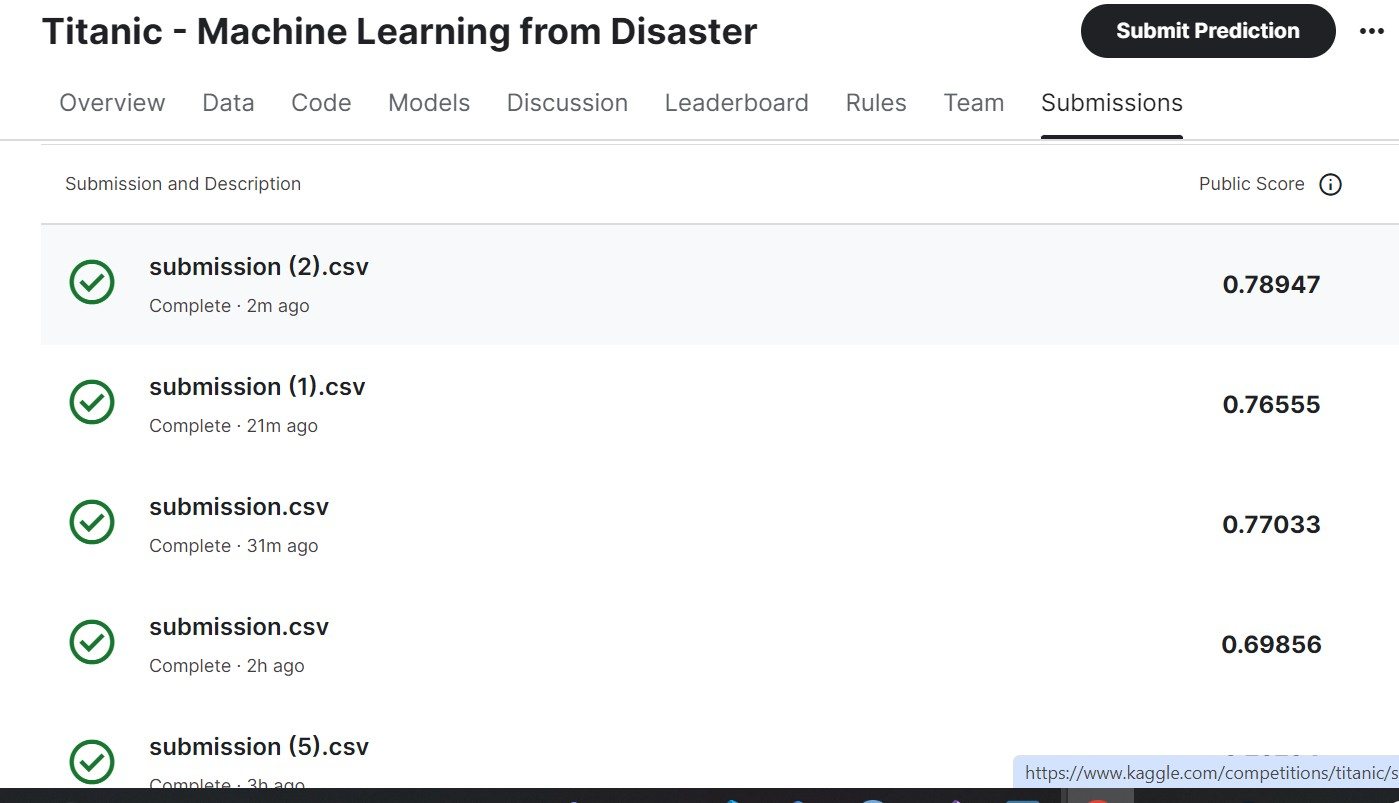

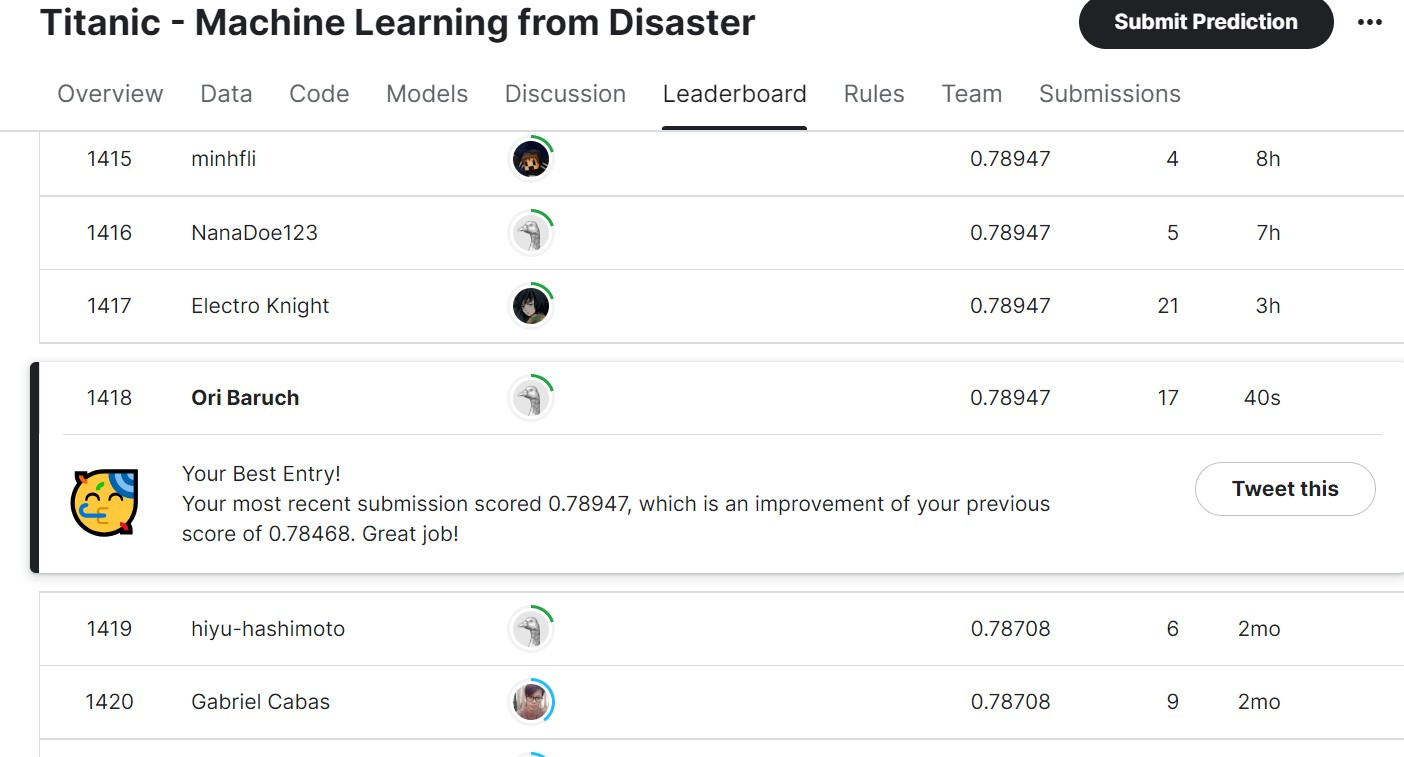

# summery

While all models achieved high 0.7s accuracy, KNeighbors Classifier stood out with an accuracy surpassing 0.8.
Overfitting was addressed by feature selection, identifying 'Pclass', 'Fare', and 'Sex_male' as significant features. 
The final model, KNeighbors Classifier, was chosen based on cross-validation performance. 
A confusion matrix was employed for model evaluation, highlighting its effectiveness

# resources
lessons 4,5,6,7,8